## The goal: There's a weird signal in surface zonal wind (enclosed regions). Is it real? And if so, why is it there? 
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 16 Sept 2020 <br><br>

In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib as matplotlib
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import Ngl
import numpy
import Nio
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import regionmask
import pickle


## Read in data 

In [2]:
# Set up directories 
dataDir    = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/'
nameStart  = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd_UV = '_UV.nc'

#decadeList = ['1951-59','1960-69', '1970-79','1980-89','1990-99','2000-14']
decadeList = ['1970-79','1980-89','1990-99','2000-14']


In [3]:
# Read in example file to get some constant fields
testName = dataDir+nameStart+'1990-01.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landFrac = np.squeeze(testDF.LANDFRAC.values)
# Define as 'land' gridcell if land fraction > 0.5
landMask = np.full([len(lat),len(lon)],np.nan)
landMask[landFrac > 0.5] = 1


In [4]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 

    UVfile = dataDir+nameStart+decadeList[iDec]+nameEnd_UV 
    windDF = xr.open_dataset(UVfile, decode_times=True)
    windDF['time'] = windDF.indexes['time'].to_datetimeindex()
    
    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullUV = windDF
    else:
        fullUV = xr.concat([fullUV, windDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullUV['time']))
    

<ipython-input-4-9b70b6ba5260>:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  windDF['time'] = windDF.indexes['time'].to_datetimeindex()


Done with decade  1970-79  ... 
    Number of times saved:  120
Done with decade  1980-89  ... 
    Number of times saved:  240
Done with decade  1990-99  ... 
    Number of times saved:  360
Done with decade  2000-14  ... 
    Number of times saved:  540


In [5]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullUV['time'].values) 


In [13]:
# Isolate lat and lon
lon = fullUV.lon.values
lat = fullUV.lat.values


### Flip levels

In [6]:
# Isolate U and flip 
U          = fullUV.U              # Zonal wind (m/s)
U          = np.flip(U, axis=1)
lev_middle = np.flip(fullUV.lev.values)


In [7]:
# Sanity check that flip worked: 
print(U.values[10,0,50,60])
print(fullUV.U.values[10,-1,50,60])


10.674347
10.674347


## Start making a few maps

In [12]:
# Get JJA 
iJJA      = np.where((dates.month>=7) & (dates.month<=9))[0]
U_JJA     = U.isel(time=iJJA)
dates_JJA = dates[iJJA]


In [14]:
# Limit to land points only 
landMask_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(landMask, lon)


<IPython.core.display.Javascript object>


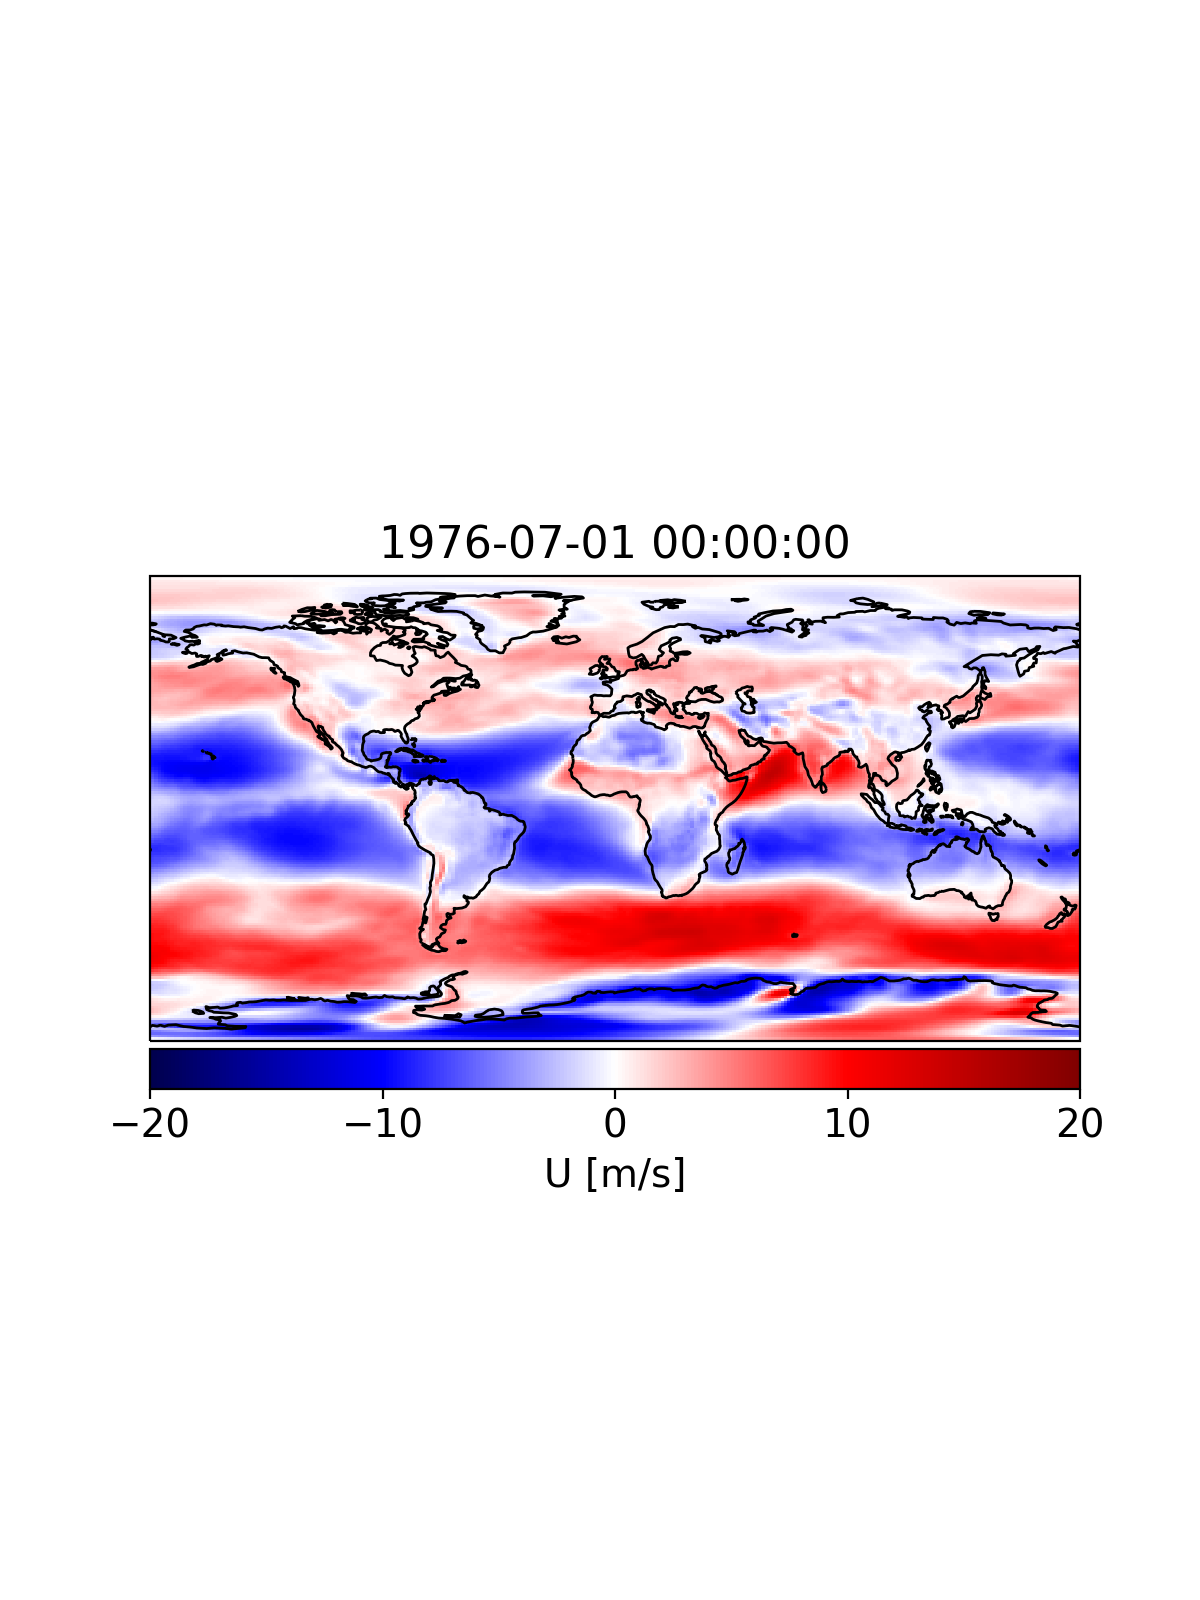

Text(0.5, 1.0, '1976-07-01 00:00:00')

In [110]:
# --- Plot globally for just one month --- # 

# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(6, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})


# Make cyclic for selected time period 
iTime = 18 
U_monCyclic, lon_cyclic = cartopy.util.add_cyclic_point(U_JJA.values[iTime,0,:,:], lon)

# Midwest US 
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_cyclic,lat,U_monCyclic,
                                 vmin = -20, 
                                 vmax = 20,
                                cmap='seismic')
ax1.coastlines()        # Add continent lines 
    
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('U [m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Set plot title 
ax1.set_title(str(dates_JJA[iTime]), fontsize=16)


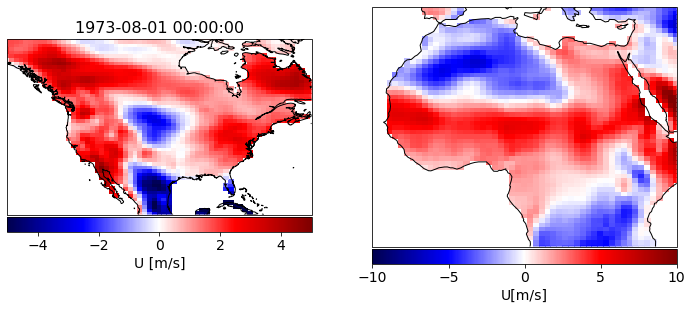

In [23]:
# --- What does wind look like for just one month? --- # 

# Set up figure 
fig, axs = plt.subplots(1,2, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
# Put axs handles in array, axs 
axs = axs.ravel()

# Make cyclic for selected time period 
iTime = 10 
U_monCyclic, lon_cyclic = cartopy.util.add_cyclic_point(U_JJA.values[iTime,0,:,:], lon)

# Midwest US 
axs[0].set_extent([220,300,20,60])
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,U_monCyclic*landMask_cyclic,
                                 vmin = -5, 
                                 vmax = 5,
                                cmap='seismic')
axs[0].coastlines()        # Add continent lines 
    
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('U [m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Set plot title 
axs[0].set_title(str(dates_JJA[iTime]), fontsize=16)



# Northern Africa 
axs[1].set_extent([340,45,-10,35])
contour_plot= axs[1].pcolormesh(lon_cyclic,lat,U_monCyclic*landMask_cyclic,
                                vmin = -10,
                                vmax = 10,
                                cmap='seismic')
axs[1].coastlines()        # Add continent lines 
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('U[m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)


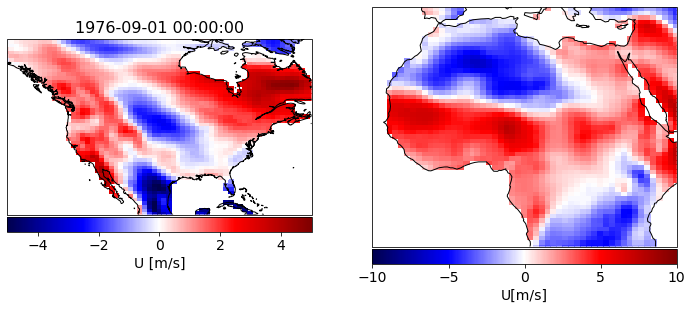

In [24]:
# --- What does wind look like for just one month? --- # 

# Set up figure 
fig, axs = plt.subplots(1,2, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
# Put axs handles in array, axs 
axs = axs.ravel()

# Make cyclic for selected time period 
iTime = 20
U_monCyclic, lon_cyclic = cartopy.util.add_cyclic_point(U_JJA.values[iTime,0,:,:], lon)

# Midwest US 
axs[0].set_extent([220,300,20,60])
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,U_monCyclic*landMask_cyclic,
                                 vmin = -5, 
                                 vmax = 5,
                                cmap='seismic')
axs[0].coastlines()        # Add continent lines 
    
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('U [m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Set plot title 
axs[0].set_title(str(dates_JJA[iTime]), fontsize=16)



# Northern Africa 
axs[1].set_extent([340,45,-10,35])
contour_plot= axs[1].pcolormesh(lon_cyclic,lat,U_monCyclic*landMask_cyclic,
                                vmin = -10,
                                vmax = 10,
                                cmap='seismic')
axs[1].coastlines()        # Add continent lines 
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('U[m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)



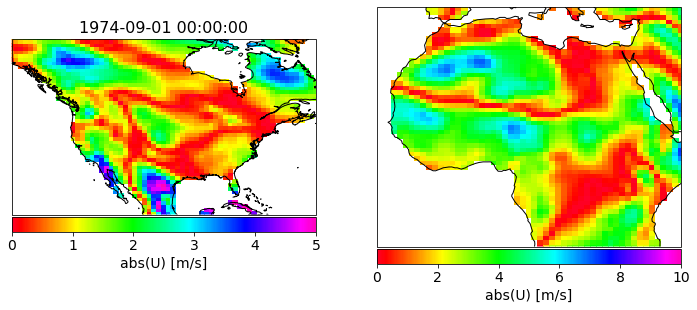

In [21]:
# --- What does wind look like for just one month? --- # 

# Set up figure 
fig, axs = plt.subplots(1,2, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
# Put axs handles in array, axs 
axs = axs.ravel()

# Make cyclic for selected time period 
iTime = 14
U_monCyclic, lon_cyclic = cartopy.util.add_cyclic_point(U_JJA.values[iTime,0,:,:], lon)

# Midwest US 
axs[0].set_extent([220,300,20,60])
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,np.abs(U_monCyclic)*landMask_cyclic,
                                 vmin = 0, 
                                 vmax = 5,
                                cmap='gist_rainbow')
axs[0].coastlines()        # Add continent lines 
    
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('abs(U) [m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Set plot title 
axs[0].set_title(str(dates_JJA[iTime]), fontsize=16)



# Northern Africa 
axs[1].set_extent([340,45,-10,35])
contour_plot= axs[1].pcolormesh(lon_cyclic,lat,np.abs(U_monCyclic)*landMask_cyclic,
                                vmin = 0,
                                vmax = 10,
                                cmap='gist_rainbow')
axs[1].coastlines()        # Add continent lines 
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('abs(U) [m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)



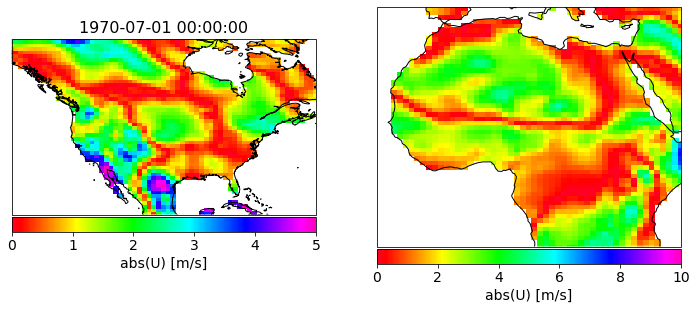

In [22]:
# --- What does wind look like for just one month? --- # 

# Set up figure 
fig, axs = plt.subplots(1,2, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
# Put axs handles in array, axs 
axs = axs.ravel()

# Make cyclic for selected time period 
iTime = 0
U_monCyclic, lon_cyclic = cartopy.util.add_cyclic_point(U_JJA.values[iTime,0,:,:], lon)

# Midwest US 
axs[0].set_extent([220,300,20,60])
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,np.abs(U_monCyclic)*landMask_cyclic,
                                 vmin = 0, 
                                 vmax = 5,
                                cmap='gist_rainbow')
axs[0].coastlines()        # Add continent lines 
    
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('abs(U) [m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Set plot title 
axs[0].set_title(str(dates_JJA[iTime]), fontsize=16)



# Northern Africa 
axs[1].set_extent([340,45,-10,35])
contour_plot= axs[1].pcolormesh(lon_cyclic,lat,np.abs(U_monCyclic)*landMask_cyclic,
                                vmin = 0,
                                vmax = 10,
                                cmap='gist_rainbow')
axs[1].coastlines()        # Add continent lines 
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('abs(U) [m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)




### Can we create animations to view more easily?
Grabbed code from here: https://towardsdatascience.com/how-to-create-animated-graphs-in-python-bb619cc2dec1 and adapted accordingly :) 

**First, animate raw monthly sfc U**

<IPython.core.display.Javascript object>


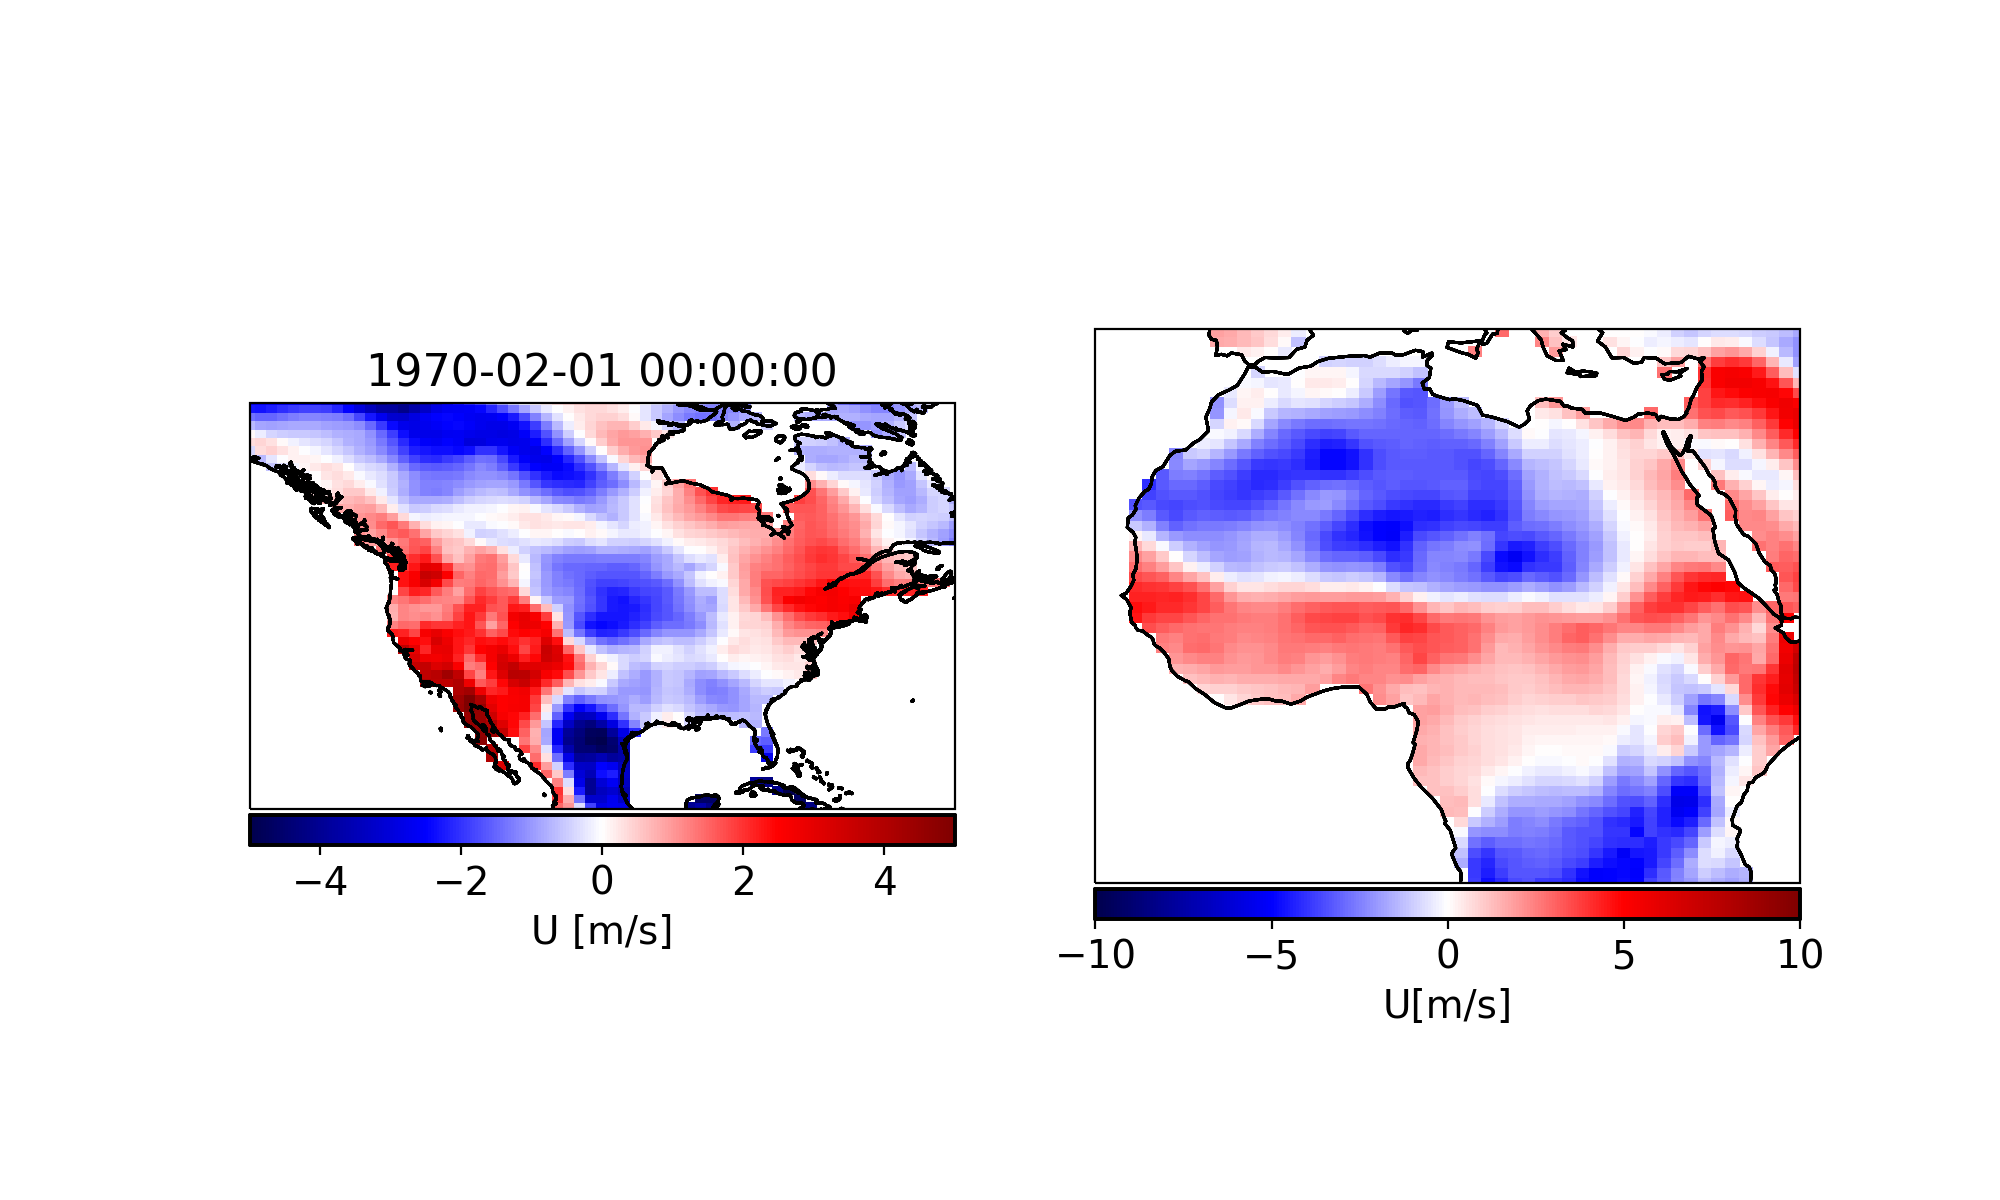

<ipython-input-35-09952bebbb44>:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
<ipython-input-35-09952bebbb44>:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])


In [35]:
# Animate raw surface U (ilev=0)

%matplotlib notebook

# Initialize a writer 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=8, metadata=dict(artist='Me'), bitrate=1800)

# Now create figure 
fig, axs = plt.subplots(1,2, figsize=(10, 6), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

axs[0].set_extent([220,300,20,60])
axs[1].set_extent([340,45,-10,35])

U_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(U_JJA.values[:,0,:,:], lon)


def animate(i):
    data = U_cyclic[i,:,:] #select data range
    day  = dates[i]
    
    contour_plot = axs[0].pcolormesh(lon_cyclic,lat,data*landMask_cyclic,
                                     vmin = -5, 
                                     vmax = 5,
                                     cmap='seismic')
    axs[0].coastlines()        # Add continent lines 

    # Add colorbar 
    ax_position = axs[0].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    cbar.set_label('U [m/s]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    # Set plot title 
    axs[0].set_title(str(day), fontsize=16)

    contour_plot= axs[1].pcolormesh(lon_cyclic,lat,data*landMask_cyclic,
                                    vmin = -10,
                                    vmax = 10,
                                    cmap='seismic')
    axs[1].coastlines()        # Add continent lines 

    # Add colorbar 
    ax_position = axs[1].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    cbar.set_label('U[m/s]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=12, repeat=True)

ani.save('MonthlySfcU_regional_1970.mp4', writer=writer)


<IPython.core.display.Javascript object>


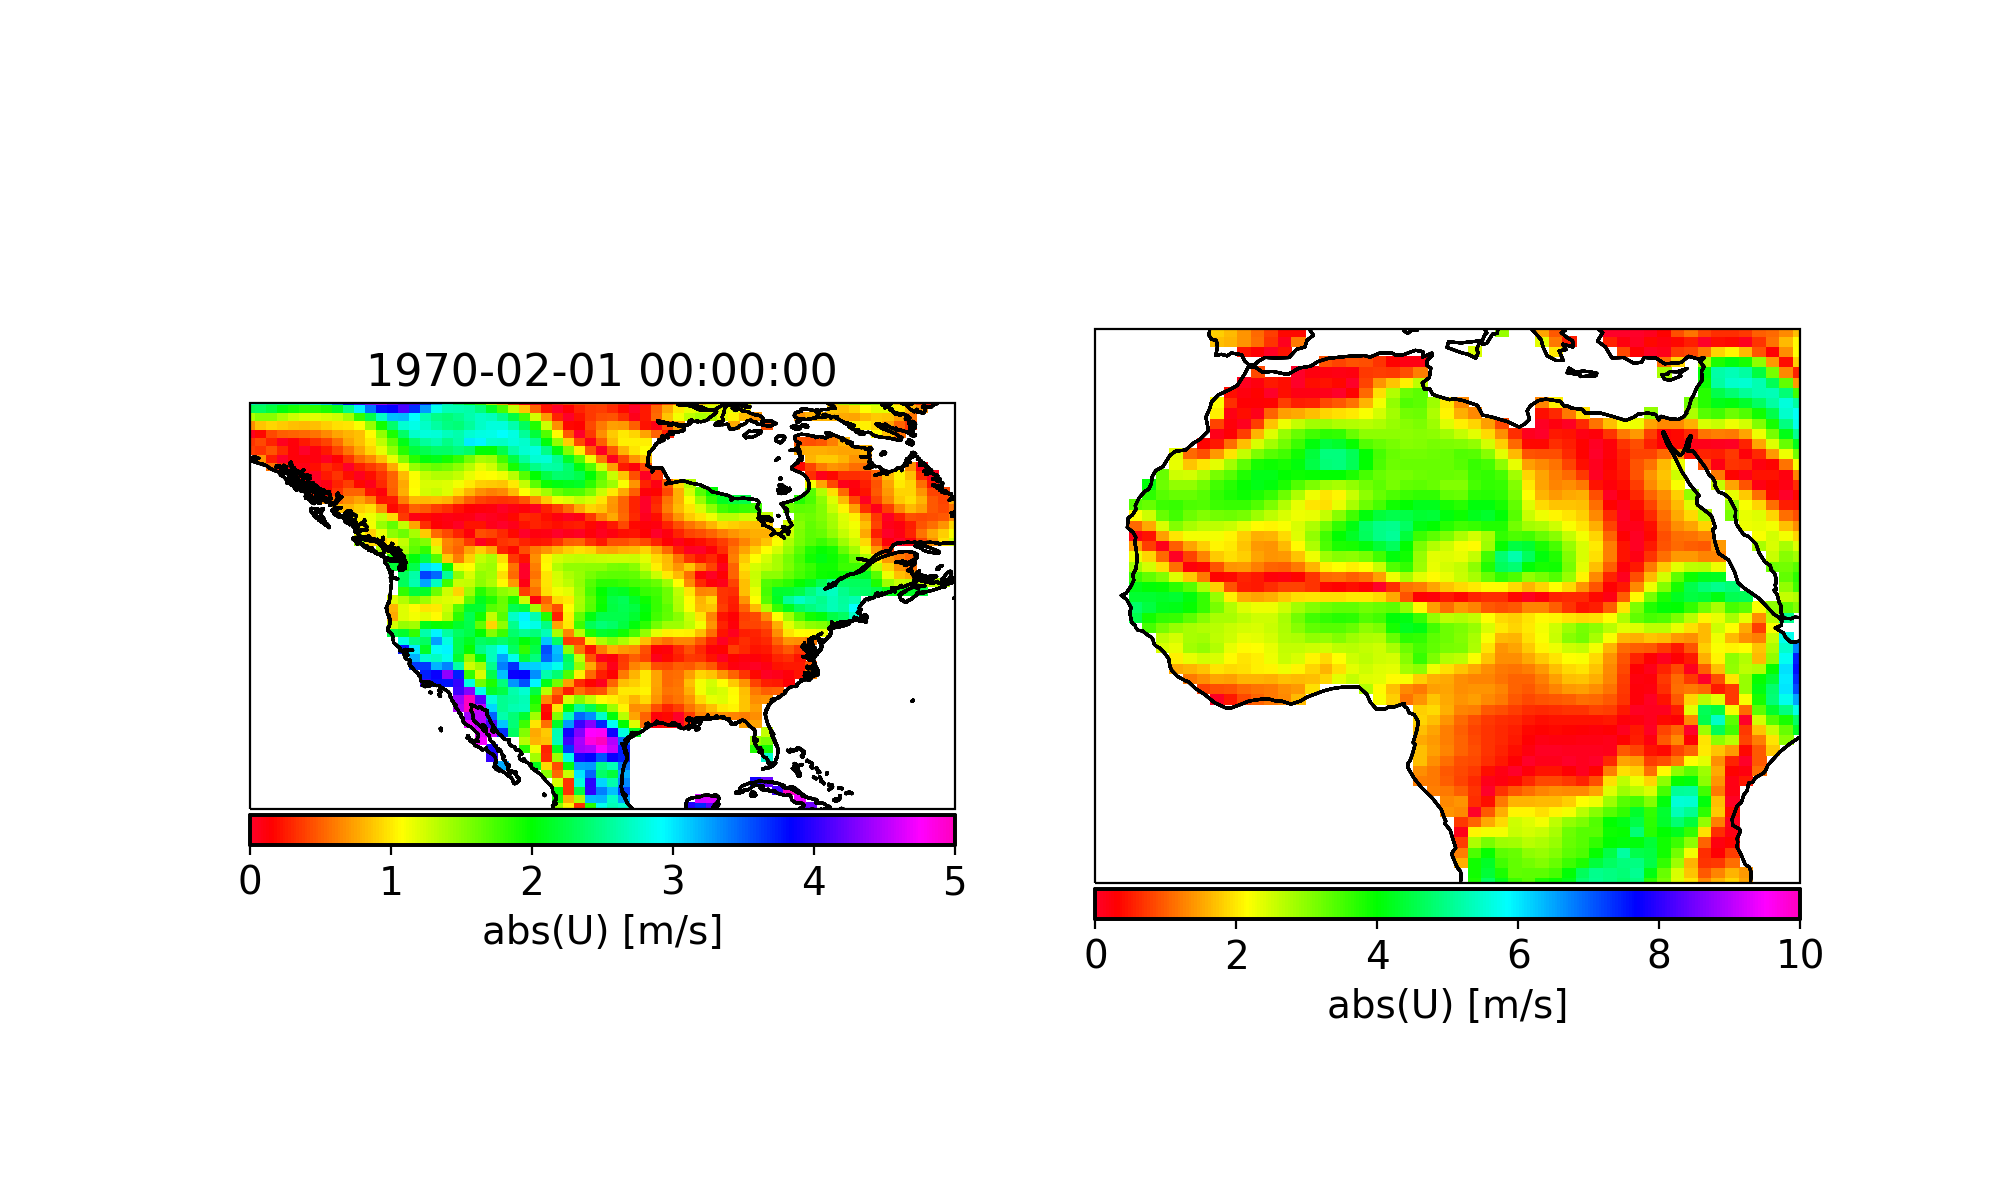

<ipython-input-73-eba472cf7aa7>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
<ipython-input-73-eba472cf7aa7>:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])


In [73]:
# Animate absolute value of surface U (ilev=0) to get just the magnitude

%matplotlib notebook

# Initialize a writer 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=8, metadata=dict(artist='Me'), bitrate=1800)

# Now create figure 
fig, axs = plt.subplots(1,2, figsize=(10, 6), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

axs[0].set_extent([220,300,20,60])
axs[1].set_extent([340,45,-10,35])

U_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(U_JJA.values[:,0,:,:], lon)


def animate(i):
    data = np.abs(U_cyclic[i,:,:]) #select data range
    day  = dates[i]
    
    contour_plot = axs[0].pcolormesh(lon_cyclic,lat,data*landMask_cyclic,
                                     vmin = 0, 
                                     vmax = 5,
                                     cmap='gist_rainbow')
    axs[0].coastlines()        # Add continent lines 

    # Add colorbar 
    ax_position = axs[0].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    cbar.set_label('abs(U) [m/s]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    # Set plot title 
    axs[0].set_title(str(day), fontsize=16)

    contour_plot= axs[1].pcolormesh(lon_cyclic,lat,data*landMask_cyclic,
                                    vmin = 0,
                                    vmax = 10,
                                    cmap='gist_rainbow')
    axs[1].coastlines()        # Add continent lines 

    # Add colorbar 
    ax_position = axs[1].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    cbar.set_label('abs(U) [m/s]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    
ani3 = matplotlib.animation.FuncAnimation(fig, animate, frames=12, repeat=True)

ani3.save('MonthlySfcU_regional_1970-abs.mp4', writer=writer)


In [80]:
print('Levels of U: \n', lev_middle[0:6])

Levels of U: 
 [992.55609512 976.32540739 957.48547954 936.19839847 912.64454694
 887.02024892]


<IPython.core.display.Javascript object>


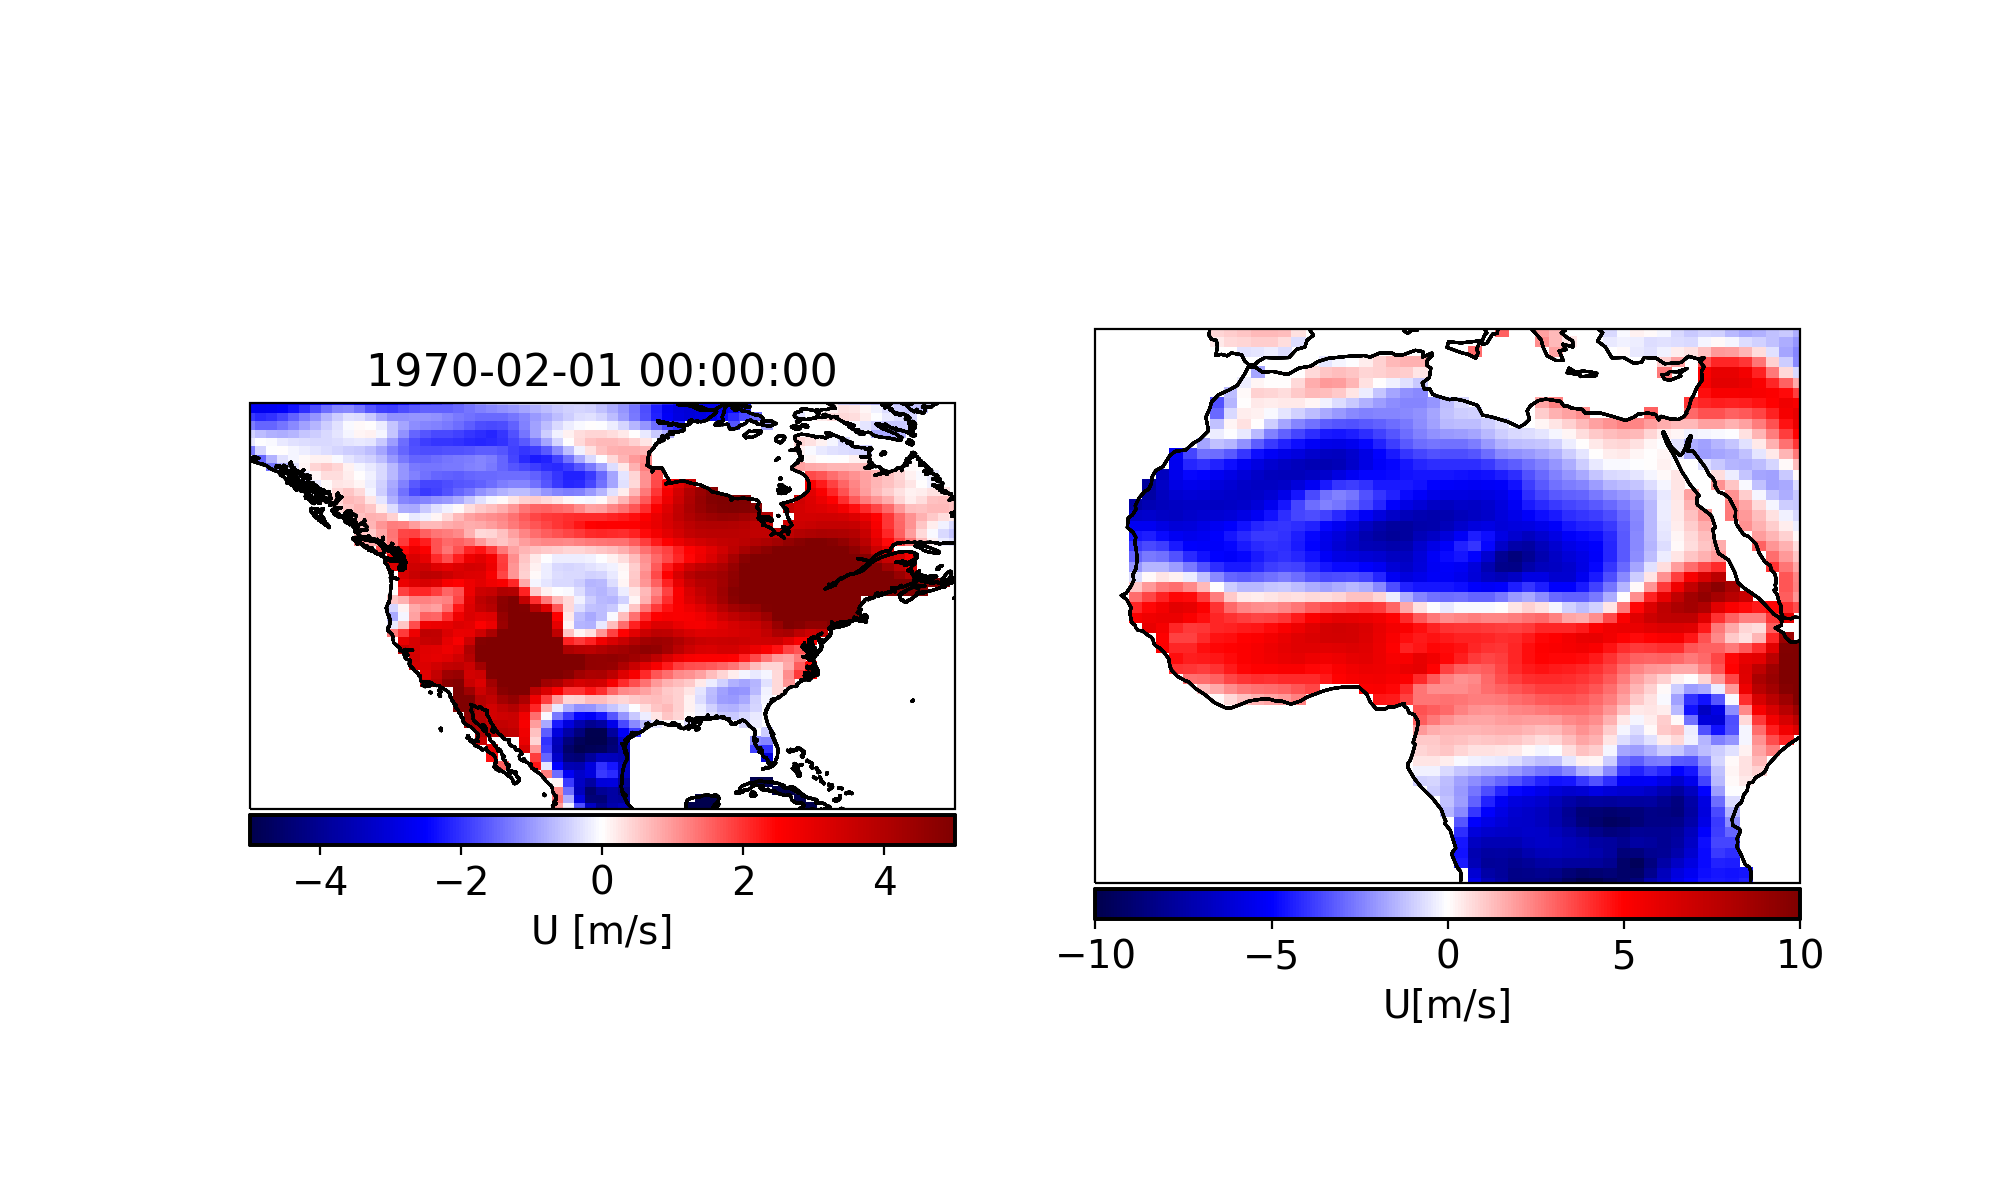

<ipython-input-79-43397fef78ce>:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
<ipython-input-79-43397fef78ce>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])


In [79]:
# Animate the raw zonal wind at some level above the sfc, defined by iLev 

%matplotlib notebook

# Initialize a writer 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=8, metadata=dict(artist='Me'), bitrate=1800)

# Now create figure 
fig, axs = plt.subplots(1,2, figsize=(10, 6), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

axs[0].set_extent([220,300,20,60])
axs[1].set_extent([340,45,-10,35])

# Choose level and make cyclic 
iLev = 4
U_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(U_JJA.values[:,iLev,:,:], lon)

def animate(i):
    data = U_cyclic[i,:,:] #select data range
    day  = dates[i]
    
    contour_plot = axs[0].pcolormesh(lon_cyclic,lat,data*landMask_cyclic,
                                     vmin = -5, 
                                     vmax = 5,
                                     cmap='seismic')
    axs[0].coastlines()        # Add continent lines 

    # Add colorbar 
    ax_position = axs[0].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    cbar.set_label('U [m/s]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    # Set plot title 
    axs[0].set_title(str(day), fontsize=16)

    contour_plot= axs[1].pcolormesh(lon_cyclic,lat,data*landMask_cyclic,
                                    vmin = -10,
                                    vmax = 10,
                                    cmap='seismic')
    axs[1].coastlines()        # Add continent lines 

    # Add colorbar 
    ax_position = axs[1].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    cbar.set_label('U[m/s]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    
ani5 = matplotlib.animation.FuncAnimation(fig, animate, frames=12, repeat=True)

ani5.save('MonthlySfcU_regional_1970-ilev'+str(iLev)+'.mp4', writer=writer)



**What about plotting annual JJA average?**

In [59]:
# First compute the JJA average by year 

yrStart   = 1970
nYrs      = int(len(dates_JJA)/3)
U_JJAmean = np.full([nYrs, len(lat), len(lon)], np. nan)

for iYr in range(nYrs):
    yrSel = np.where(dates_JJA.year==yrStart)[0]
    
    U_JJAmean[iYr,:,:] = np.nanmean(U_JJA[yrSel,0,:,:], axis=0)
    
    yrStart = yrStart+1 


<ipython-input-58-e21bd8b826fe>:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])


<IPython.core.display.Javascript object>


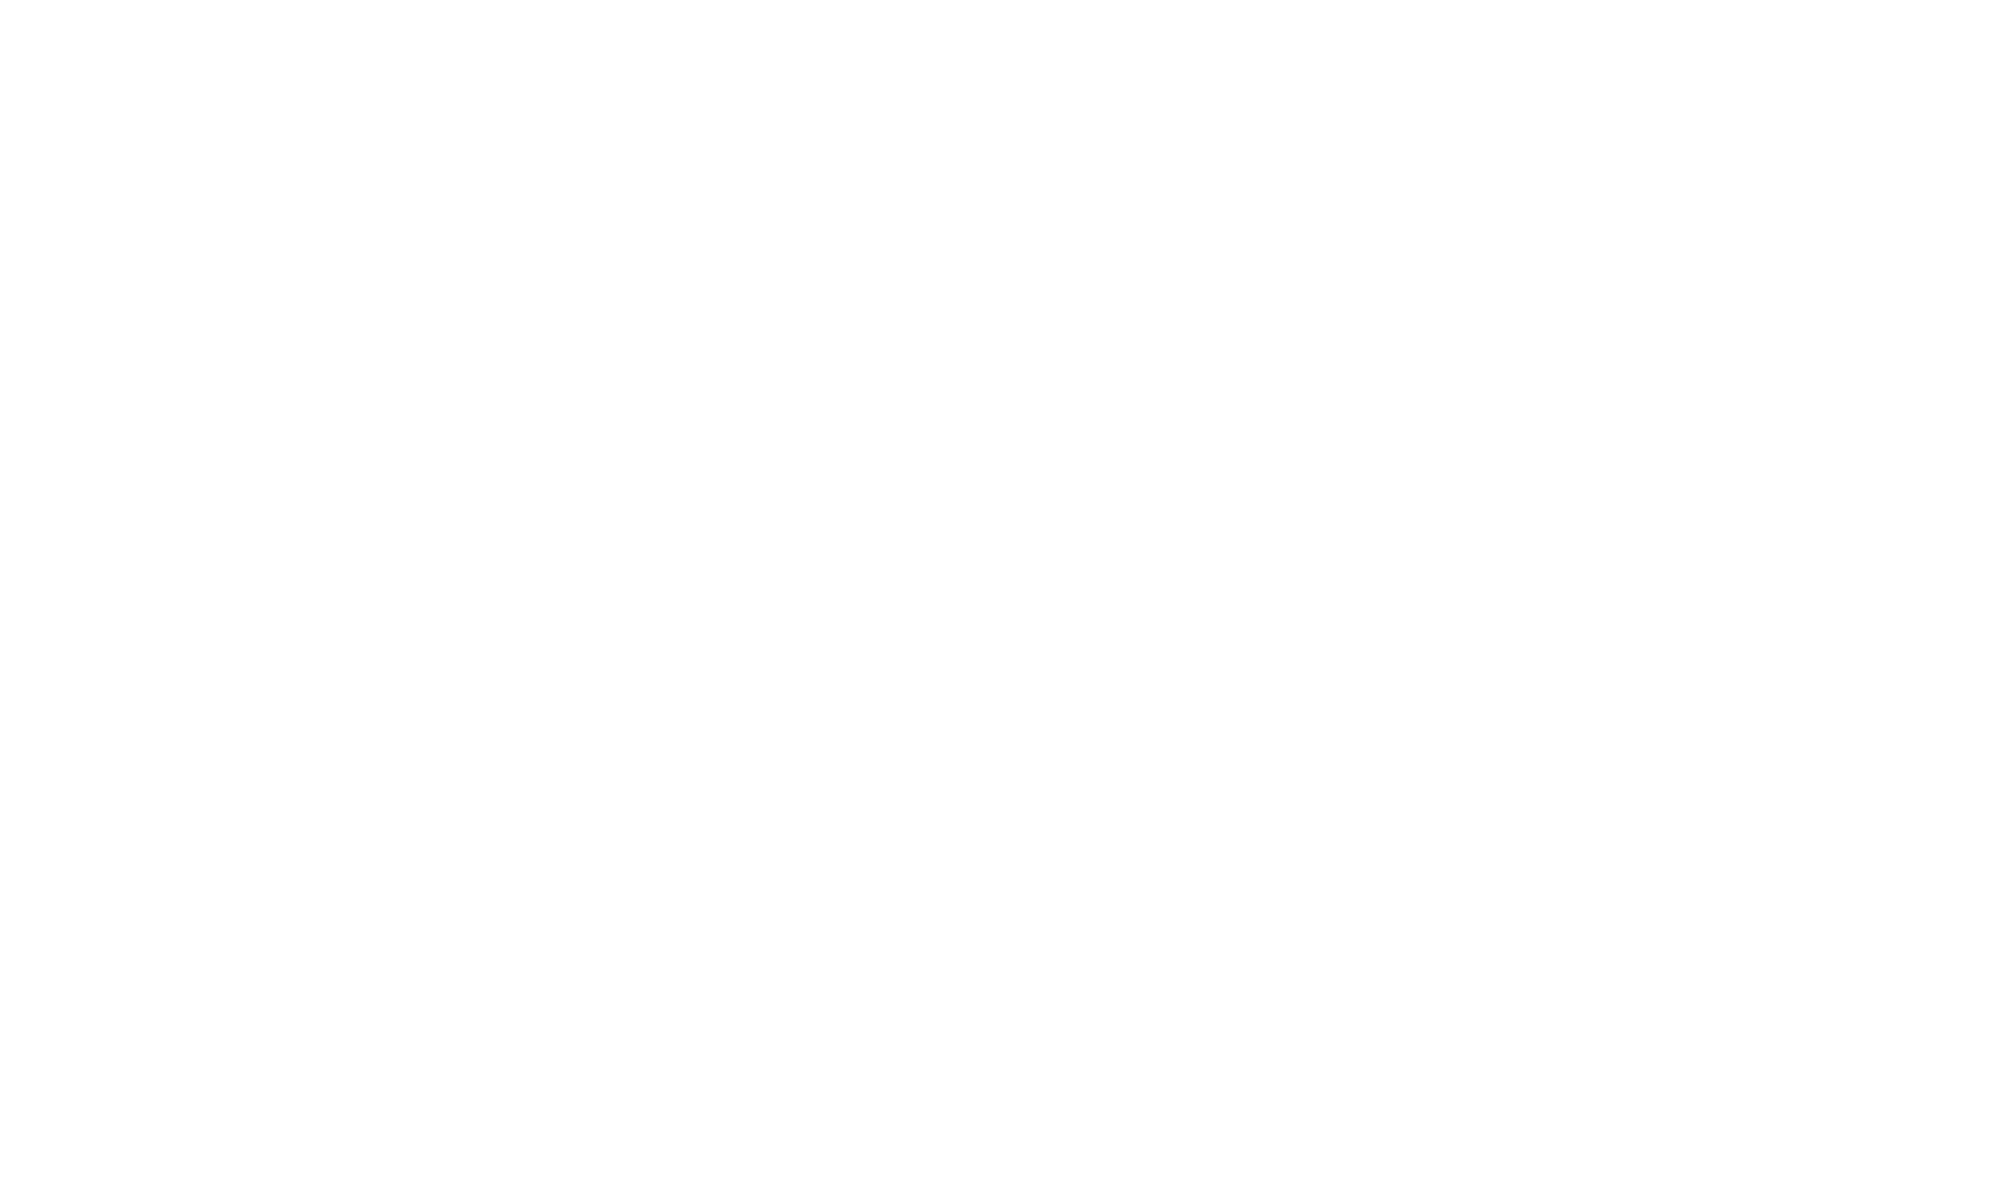

<ipython-input-62-a6a2ce02565e>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
<ipython-input-62-a6a2ce02565e>:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])


In [62]:
# Create animation of annual JJA sfc wind 

%matplotlib notebook

# Initialize a writer 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=8, metadata=dict(artist='Me'), bitrate=1800)

# Now create figure 
fig, axs = plt.subplots(1,2, figsize=(10, 6), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

axs[0].set_extent([220,300,20,60])
axs[1].set_extent([340,45,-10,35])

U_JJA_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(U_JJAmean, lon)

yrArr = np.linspace(1970, 2014, nYrs)

def animateAnnual(i):
    data = U_JJA_cyclic[i,:,:] #select data range
    
    contour_plot = axs[0].pcolormesh(lon_cyclic,lat,data*landMask_cyclic,
                                     vmin = -5, 
                                     vmax = 5,
                                     cmap='seismic')
    axs[0].coastlines()        # Add continent lines 

    # Add colorbar 
    ax_position = axs[0].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    cbar.set_label('U [m/s]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    # Set plot title 
    axs[0].set_title('JJA: '+str(yrArr[i]), fontsize=16)

    contour_plot= axs[1].pcolormesh(lon_cyclic,lat,data*landMask_cyclic,
                                    vmin = -10,
                                    vmax = 10,
                                    cmap='seismic')
    axs[1].coastlines()        # Add continent lines 

    # Add colorbar 
    ax_position = axs[1].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    cbar.set_label('U[m/s]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    

    
ani2 = matplotlib.animation.FuncAnimation(fig, animateAnnual, frames=nYrs, repeat=True)

#plt.show()
ani2.save('MonthlySfcU_regional_JJAannMean.mp4', writer=writer)


## Is any of this in U10, from CLM?

In [85]:
dataDir    = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/'
nameStart  = 'f.e20.FHIST.f09_f09.cesm2_1.001.clm2.h0.'
nameEnd    = '_lndWindVars.nc'
decadeList = ['1970-79','1980-89','1990-99','2000-14']

# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 

    CLMfile = dataDir+nameStart+decadeList[iDec]+nameEnd
    clmDF = xr.open_dataset(CLMfile, decode_times=True)
    clmDF['time'] = clmDF.indexes['time'].to_datetimeindex()
    
    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullCLM = clmDF
    else:
        fullCLM = xr.concat([fullCLM, clmDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullCLM['time']))


<ipython-input-85-cb6cc62152cf>:13: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDF['time'] = clmDF.indexes['time'].to_datetimeindex()


Done with decade  1970-79  ... 
    Number of times saved:  120
Done with decade  1980-89  ... 
    Number of times saved:  240
Done with decade  1990-99  ... 
    Number of times saved:  360
Done with decade  2000-14  ... 
    Number of times saved:  540


In [64]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullCLM['time'].values) 

# Isolate lat and lon 
lat = fullCLM.lat.values
lon = fullCLM.lon.values


In [65]:
fullCLM

<xarray.Dataset>
Dimensions:      (hist_interval: 2, lat: 192, lon: 288, time: 540)
Coordinates:
  * lat          (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon          (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.25 357.5 358.75
  * time         (time) datetime64[ns] 1970-02-01 1970-03-01 ... 2015-01-01
Dimensions without coordinates: hist_interval
Data variables:
    time_bounds  (time, hist_interval) object 1970-01-01 00:00:00 ... 2015-01...
    TAUX         (time, lat, lon) float32 0.0129726 0.012562465 ... nan nan
    TAUY         (time, lat, lon) float32 0.018659346 0.018937897 ... nan nan
    U10          (time, lat, lon) float32 3.475148 3.4751477 ... nan nan
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   Wed Sep 16 07:39:59 2020: ncrc...
    source:                                    Community Land Model CLM4.0
    hostname:                                  cheyenne
    username:                                  hannay
    version:                                   cesm2_1_alpha01d
    revision_id:                               $Id: histFileMod.F90 42903 201...
    case_title:                                UNSET
    case_id:                                   f.e20.FHIST.f09_f09.cesm2_1.001
    Surface_dataset:                           surfdata_0.9x1.25_16pfts_Irrig...
    Initial_conditions_dataset:                arbitrary initialization
    PFT_physiological_constants_dataset:       clm5_params.c171117.nc
    ltype_vegetated_or_bare_soil:              1
    ltype_crop:                                2
    ltype_UNUSED:                              3
    ltype_landice_multiple_elevation_classes:  4
    ltype_deep_lake:                           5
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    ctype_vegetated_or_bare_soil:              1
    ctype_crop:                                2
    ctype_crop_noncompete:                     2*100+m, m=cft_lb,cft_ub
    ctype_landice:                             3
    ctype_landice_multiple_elevation_classes:  4*100+m, m=1,glcnec
    ctype_deep_lake:                           5
    ctype_wetland:                             6
    ctype_urban_roof:                          71
    ctype_urban_sunwall:                       72
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    NCO:                                       netCDF Operators version 4.7.9...

In [86]:
# Read in U10
U10 = fullCLM.U10 

# Isolate JJA 
iJJA      = np.where((dates.month>=7) & (dates.month<=9))[0]
U10_JJA   = U10.isel(time=iJJA)
dates_JJA = dates[iJJA]

<IPython.core.display.Javascript object>


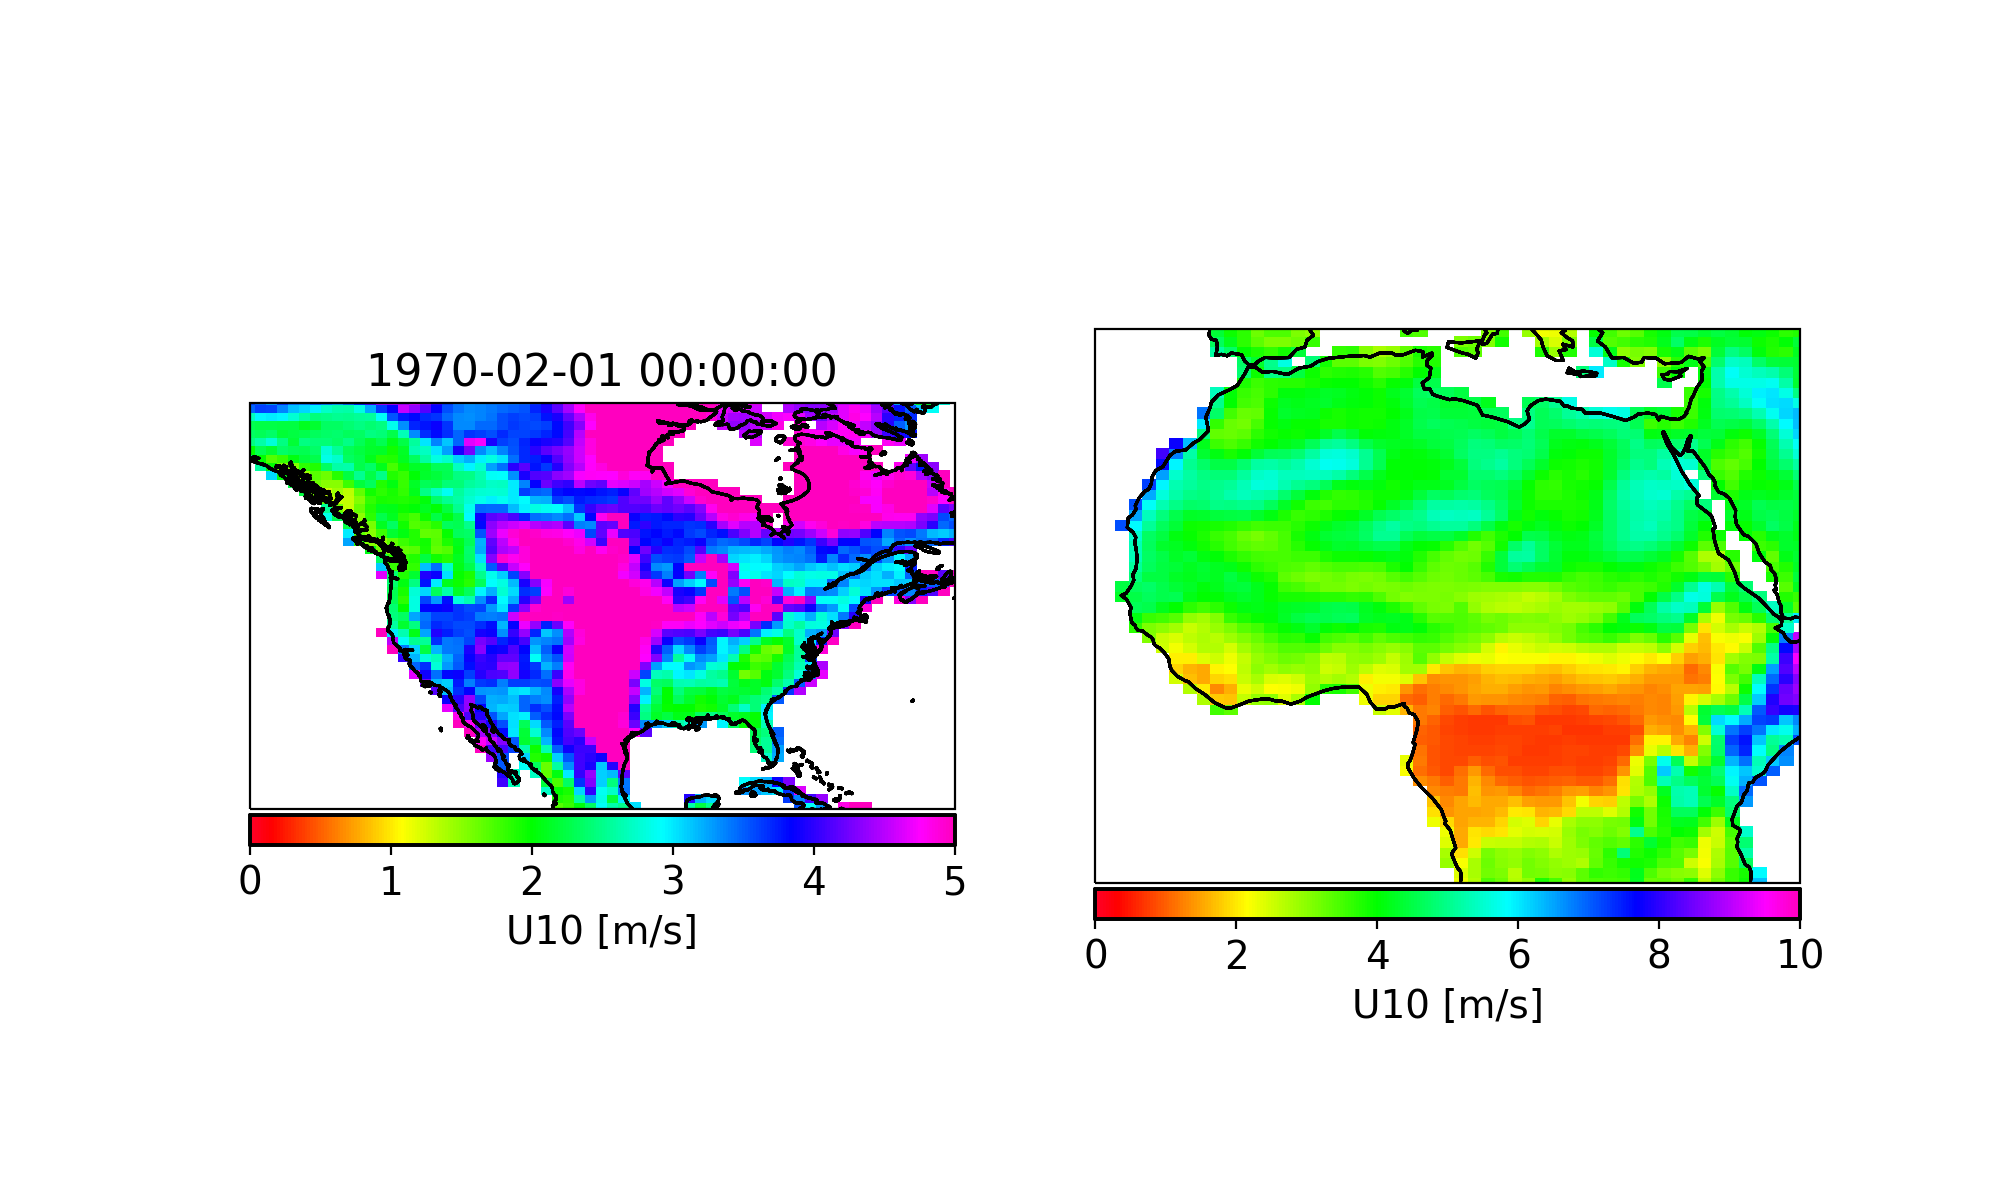

<ipython-input-75-00bc7e54ebe0>:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
<ipython-input-75-00bc7e54ebe0>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])


In [75]:
# Can we create an animation...? 

%matplotlib notebook

# Initialize a writer 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=8, metadata=dict(artist='Me'), bitrate=1800)

# Now create figure 
fig, axs = plt.subplots(1,2, figsize=(10, 6), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

axs[0].set_extent([220,300,20,60])
axs[1].set_extent([340,45,-10,35])

U10_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(U10_JJA.values, lon)

def animate(i):
    data = U10_cyclic[i,:,:] #select data range
    day  = dates[i]
    
    contour_plot = axs[0].pcolormesh(lon_cyclic,lat,data,
                                     vmin = 0, 
                                     vmax = 5,
                                     cmap='gist_rainbow')
    axs[0].coastlines()        # Add continent lines 

    # Add colorbar 
    ax_position = axs[0].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    cbar.set_label('U10 [m/s]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    # Set plot title 
    axs[0].set_title(str(day), fontsize=16)

    contour_plot= axs[1].pcolormesh(lon_cyclic,lat,data,
                                    vmin = 0,
                                    vmax = 10,
                                    cmap='gist_rainbow')
    axs[1].coastlines()        # Add continent lines 

    # Add colorbar 
    ax_position = axs[1].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    cbar.set_label('U10 [m/s]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    
ani4 = matplotlib.animation.FuncAnimation(fig, animate, frames=12, repeat=True)

ani4.save('MonthlyU10_regional_1970.mp4', writer=writer)



### Quick check that U10 from CAM side is the same

In [81]:
dataDir   = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/'
fileName  = dataDir+'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.1970-2014_U10.nc'

# Read in file 
camDF = xr.open_dataset(fileName, decode_times=True)
camDF['time'] = camDF.indexes['time'].to_datetimeindex()


<ipython-input-81-3a5a3e83d658>:6: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDF['time'] = camDF.indexes['time'].to_datetimeindex()


In [84]:
# Read in U10
U10_cam = camDF.U10 

# Isolate JJA 
iJJA       = np.where((dates.month>=7) & (dates.month<=9))[0]
U10cam_JJA = U10_cam.isel(time=iJJA)
dates_JJA  = dates[iJJA]

U10cam_JJA

<xarray.DataArray 'U10' (time: 135, lat: 192, lon: 288)>
[7464960 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 1970-07-01 1970-08-01 ... 2014-09-01
Attributes:
    units:         m/s
    long_name:     10m wind speed
    cell_methods:  time: mean

In [88]:
diff_U10 = U10cam_JJA.values - U10_JJA

print(np.nanmean(diff_U10))

0.049949784


<IPython.core.display.Javascript object>


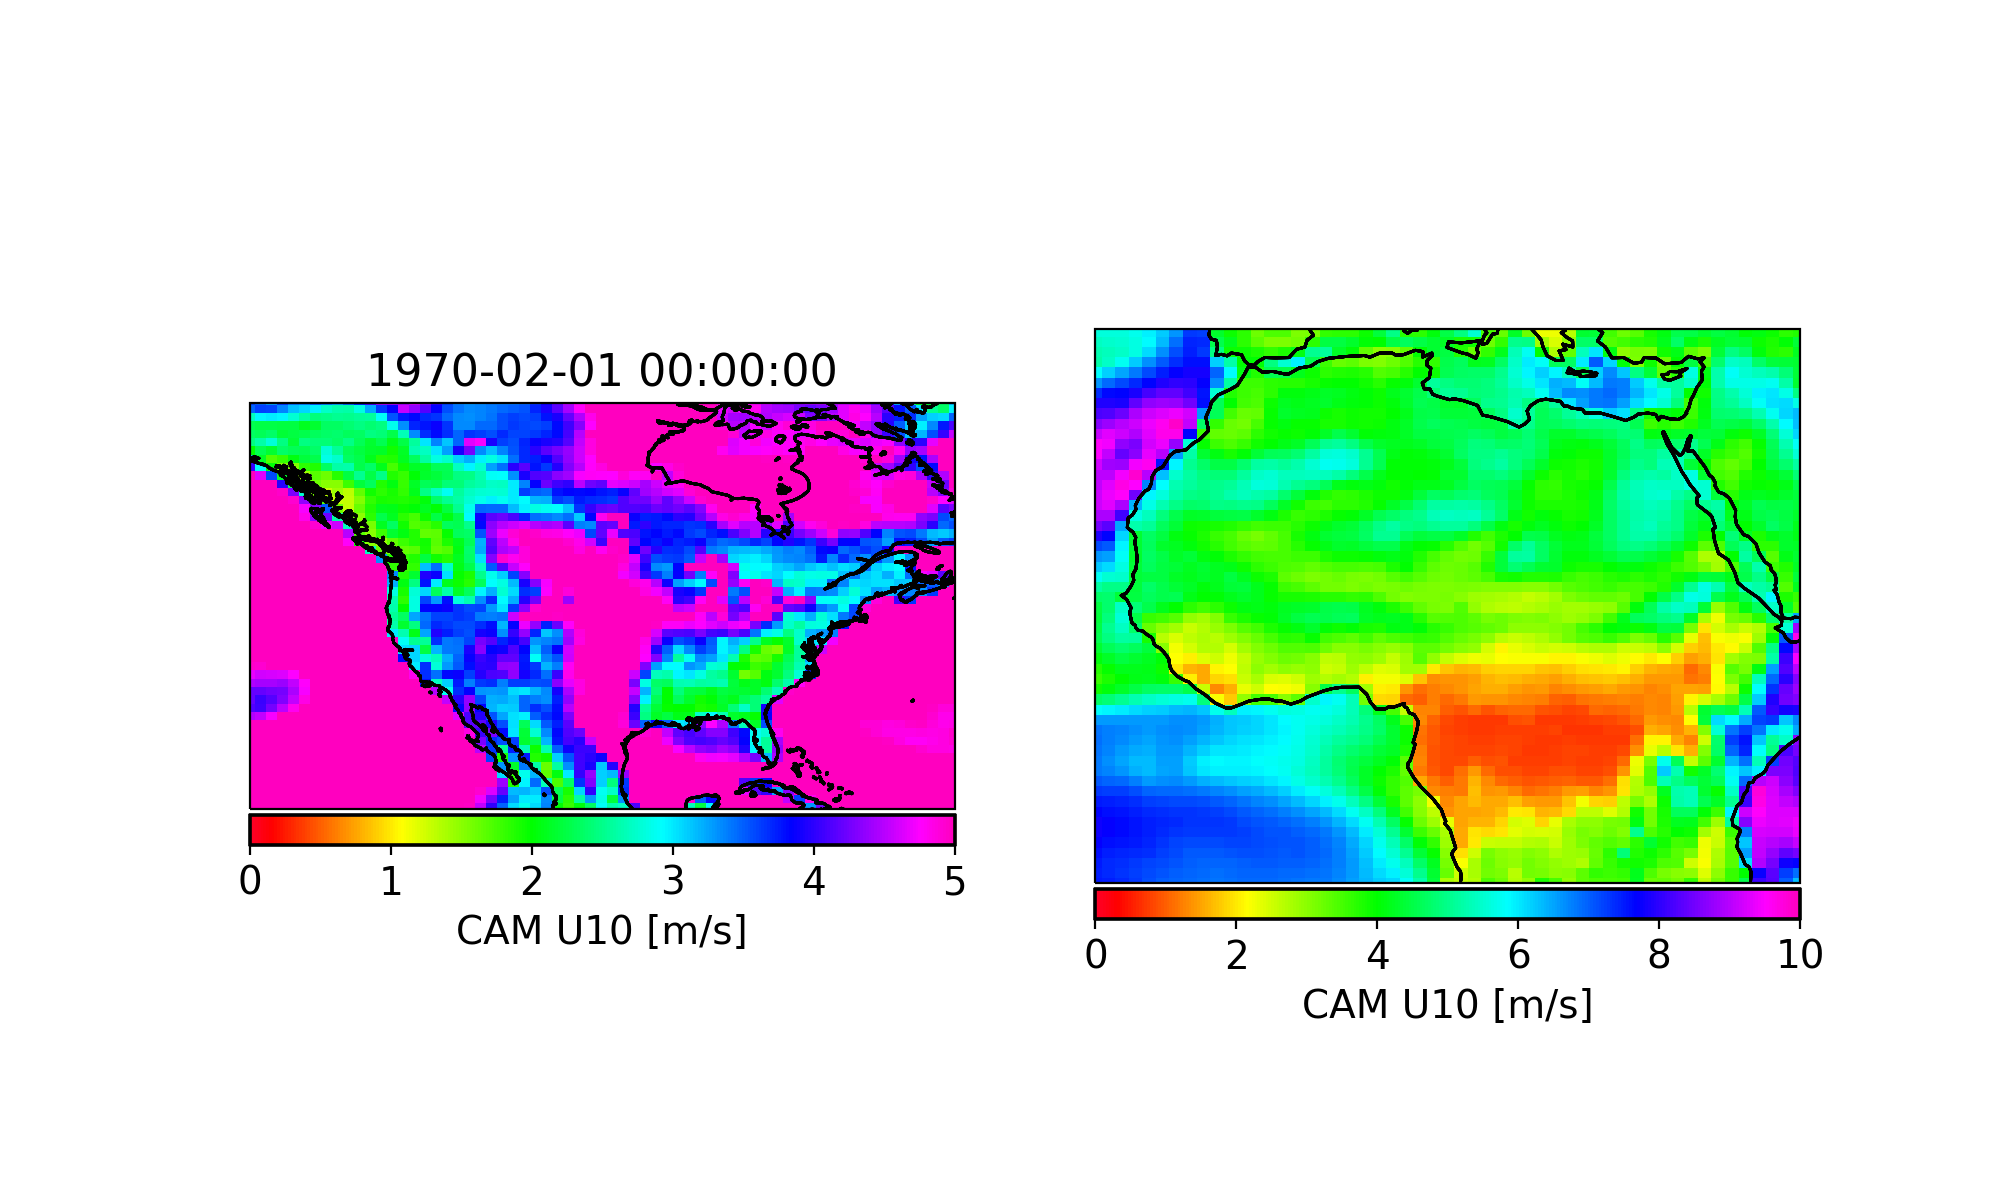

In [89]:
# Can we create an animation...? 

%matplotlib notebook

# Initialize a writer 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=8, metadata=dict(artist='Me'), bitrate=1800)

# Now create figure 
fig, axs = plt.subplots(1,2, figsize=(10, 6), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

axs[0].set_extent([220,300,20,60])
axs[1].set_extent([340,45,-10,35])

U10_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(U10cam_JJA.values, lon)

def animate(i):
    data = U10_cyclic[i,:,:] #select data range
    day  = dates[i]
    
    contour_plot = axs[0].pcolormesh(lon_cyclic,lat,data,
                                     vmin = 0, 
                                     vmax = 5,
                                     cmap='gist_rainbow')
    axs[0].coastlines()        # Add continent lines 

    # Add colorbar 
    ax_position = axs[0].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    cbar.set_label('CAM U10 [m/s]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    # Set plot title 
    axs[0].set_title(str(day), fontsize=16)

    contour_plot= axs[1].pcolormesh(lon_cyclic,lat,data,
                                    vmin = 0,
                                    vmax = 10,
                                    cmap='gist_rainbow')
    axs[1].coastlines()        # Add continent lines 

    # Add colorbar 
    ax_position = axs[1].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    cbar.set_label('CAM U10 [m/s]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    
ani6 = matplotlib.animation.FuncAnimation(fig, animate, frames=12, repeat=True)

#ani6.save('MonthlyU10_regional_1970.mp4', writer=writer)

plt.show()


<IPython.core.display.Javascript object>


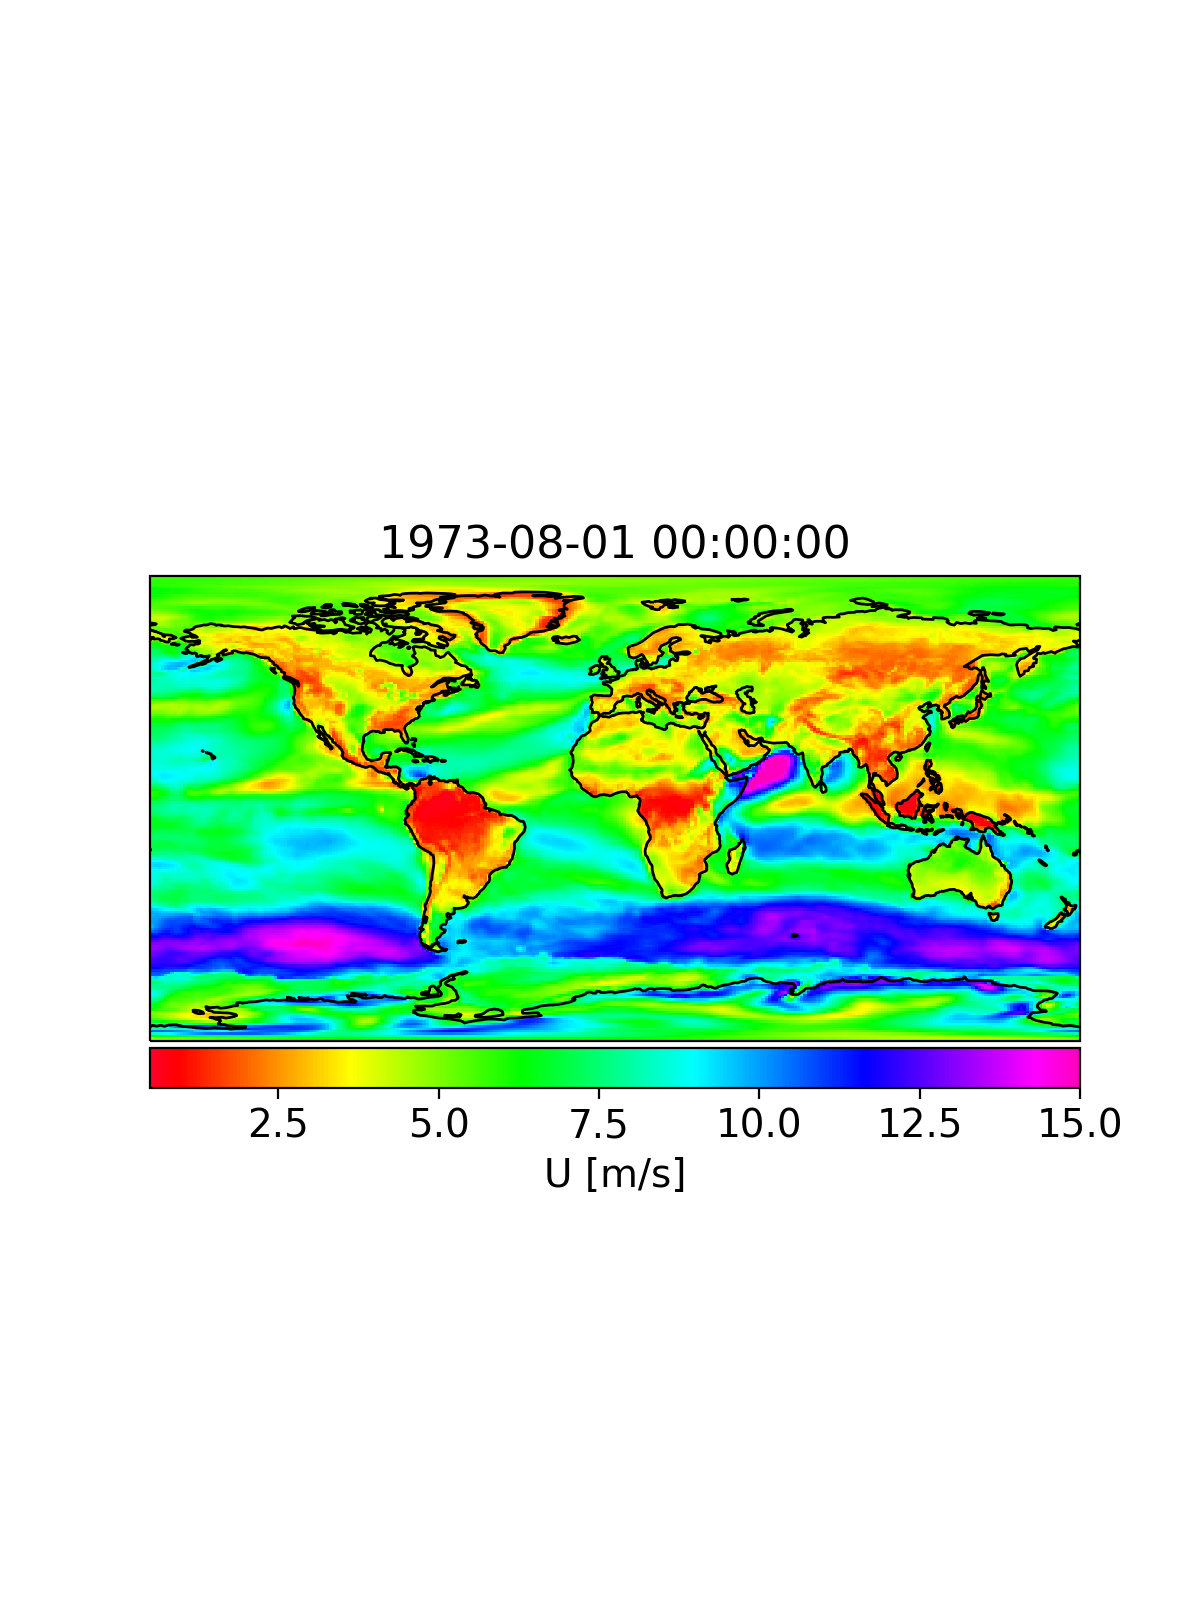

Text(0.5, 1.0, '1973-08-01 00:00:00')

In [105]:
# --- Plot globally for just one month --- # 

# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(6, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})


# Make cyclic for selected time period 
iTime = 10 
U_monCyclic, lon_cyclic = cartopy.util.add_cyclic_point(U10cam_JJA.values[iTime,:,:], lon)

# Midwest US 
#ax1.set_extent([250,330,-70,35])
ax1.set_global()

contour_plot = ax1.pcolormesh(lon_cyclic,lat,U_monCyclic,
                                 vmin = 0.5, 
                                 vmax = 15,
                                cmap='gist_rainbow')
ax1.coastlines()        # Add continent lines 
    
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('U [m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Set plot title 
ax1.set_title(str(dates_JJA[iTime]), fontsize=16)



## Placeholder 